# TODO: Predict Reviews with BERT in the Notebook (AdHoc)

# Note:  this no longer works properly as it's using the `transformers/fine-tuned` model

In [1]:
import boto3
import sagemaker
import pandas as pd

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name='sagemaker', region_name=region)

# Retrieve the Training Job Name

In [2]:
%store -r training_job_name

In [3]:
try:
    training_job_name
except NameError:
    print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    print('[ERROR] Please wait for the previous notebook to finish.')
    print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')

In [4]:
print('Previous training_job_name: {}'.format(training_job_name))

Previous training_job_name: tensorflow-training-2021-01-03-05-49-48-016


# Download the Trained Model

In [5]:
models_dir = './models'

In [6]:
# Download the model and output artifacts from AWS S3
!aws s3 cp s3://$bucket/$training_job_name/output/model.tar.gz $models_dir/model.tar.gz

download: s3://sagemaker-us-east-1-835319576252/tensorflow-training-2021-01-03-05-49-48-016/output/model.tar.gz to models/model.tar.gz


In [7]:
import tarfile
import pickle as pkl

#!ls -al ./models

tar = tarfile.open('{}/model.tar.gz'.format(models_dir))
tar.extractall(path=models_dir)
tar.close()

In [8]:
!ls -al $models_dir

total 835436
drwxrwxr-x  8 ec2-user ec2-user      4096 Jan  3 06:47 .
drwxrwxr-x 17 ec2-user ec2-user      4096 Jan  3 06:47 ..
drwxr-xr-x  2 ec2-user ec2-user      4096 Jan  3 06:07 code
drwxr-xr-x  2 ec2-user ec2-user      4096 Jan  3 06:09 metrics
-rw-rw-r--  1 ec2-user ec2-user 855452891 Jan  3 06:11 model.tar.gz
drwxr-xr-x  4 ec2-user ec2-user      4096 Jan  3 05:58 tensorboard
drwxr-xr-x  3 ec2-user ec2-user      4096 Jan  3 05:56 tensorflow
drwxr-xr-x  2 ec2-user ec2-user      4096 Jan  3 06:07 test_data
drwxr-xr-x  3 ec2-user ec2-user      4096 Jan  3 05:56 transformers


# Load the Model

In [9]:
transformer_model_dir = '{}/transformers/fine-tuned/'.format(models_dir)

!ls -al $transformer_model_dir

total 259360
drwxr-xr-x 2 ec2-user ec2-user      4096 Jan  3 05:58 .
drwxr-xr-x 3 ec2-user ec2-user      4096 Jan  3 05:56 ..
-rw-r--r-- 1 ec2-user ec2-user       648 Jan  3 05:58 config.json
-rw-r--r-- 1 ec2-user ec2-user 265569984 Jan  3 05:58 tf_model.h5


In [10]:
cat $transformer_model_dir/config.json

{
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": 1,
    "1": 2,
    "2": 3,
    "3": 4,
    "4": 5
  },
  "initializer_range": 0.02,
  "label2id": {
    "1": 0,
    "2": 1,
    "3": 2,
    "4": 3,
    "5": 4
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "vocab_size": 30522
}


In [11]:
import os
from transformers import TFDistilBertForSequenceClassification

loaded_model = TFDistilBertForSequenceClassification.from_pretrained(transformer_model_dir,
                                                                     id2label={
                                                                       0: 1,
                                                                       1: 2,
                                                                       2: 3,
                                                                       3: 4,
                                                                       4: 5
                                                                     },
                                                                     label2id={
                                                                       1: 0,
                                                                       2: 1,
                                                                       3: 2,
                                                                       4: 3,
                                                                       5: 4
                                                                     })

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at ./models/transformers/fine-tuned/ and are newly initialized: ['pre_classifier', 'classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

inference_device = -1 # CPU: -1, GPU: 0
print('inference_device {}'.format(inference_device))

inference_device -1


In [13]:
from transformers import TextClassificationPipeline

inference_pipeline = TextClassificationPipeline(model=loaded_model, 
                                                tokenizer=tokenizer,
                                                framework='tf',
                                                device=inference_device) # -1 is CPU, >= 0 is GPU

# THESE PREDICTIONS WILL NOT BE ACCURATE  

Here are the reasons:
* we are not using the full dataset
* we are only training for 50 steps
* we are using a small training cluster

_This same BERT model achieves close to 97% accuracy when training longer, using a larger training cluster, and using more data._

In [14]:
review = """I loved it!"""
print(review, inference_pipeline(review))

I loved it! [{'label': 1, 'score': 0.21490779519081116}]


In [15]:
review = """Not that good."""
print(review, inference_pipeline(review))

Not that good. [{'label': 1, 'score': 0.21912693977355957}]


# Test Model

In [16]:
import csv

df_test_reviews = pd.read_csv('./data/amazon_reviews_us_Digital_Software_v1_00.tsv.gz', 
                                delimiter='\t', 
                                quoting=csv.QUOTE_NONE,
                                compression='gzip')[['review_body', 'star_rating']]

df_test_reviews = df_test_reviews.sample(n=100)

df_test_reviews.shape

(100, 2)

# Actual Star Rating

In [17]:
df_test_reviews.head()

,review_body,star_rating
6347,"I have used Quicken for several years, but thi...",3
61100,"I have been using avast! for 2 years, and I ha...",5
94262,"After installing the software, it was very eas...",5
44047,Nice,5
81284,I have used Quicken for years. Having the mobi...,5


In [18]:
y_actual = df_test_reviews['star_rating']

y_actual

6347      3
61100     5
94262     5
44047     5
81284     5
         ..
69686     1
100189    5
43601     5
80296     1
100718    4
Name: star_rating, Length: 100, dtype: int64

# Predicted Star Rating

In [19]:
import pandas as pd

def predict(review_body):
    prediction_map = inference_pipeline(review_body[0:512])
    return prediction_map[0]['label']
    
y_test = df_test_reviews['review_body'].map(predict)

y_test

6347      1
61100     1
94262     1
44047     1
81284     1
         ..
69686     4
100189    1
43601     1
80296     4
100718    4
Name: review_body, Length: 100, dtype: int64

# Classification Report:  Compare Actual to Predicted

In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_test, y_pred=y_actual))

              precision    recall  f1-score   support

           1       0.30      0.11      0.16        56
           2       0.07      1.00      0.13         1
           3       0.00      0.00      0.00         0
           4       0.24      0.12      0.16        43
           5       0.00      0.00      0.00         0

    accuracy                           0.12       100
   macro avg       0.12      0.24      0.09       100
weighted avg       0.27      0.12      0.16       100



# Accuracy

In [21]:
from sklearn.metrics import accuracy_score

print('Test accuracy: ', accuracy_score(y_true=y_test, y_pred=y_actual))

Accuracy:  0.12


# Confusion Matrix

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_conf_mat(cm, classes, title, cmap = plt.cm.Greens):
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="black" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

[[ 6  7  3 16 24]
 [ 0  1  0  0  0]
 [ 0  0  0  0  0]
 [14  6  2  5 16]
 [ 0  0  0  0  0]]


<Figure size 432x288 with 0 Axes>

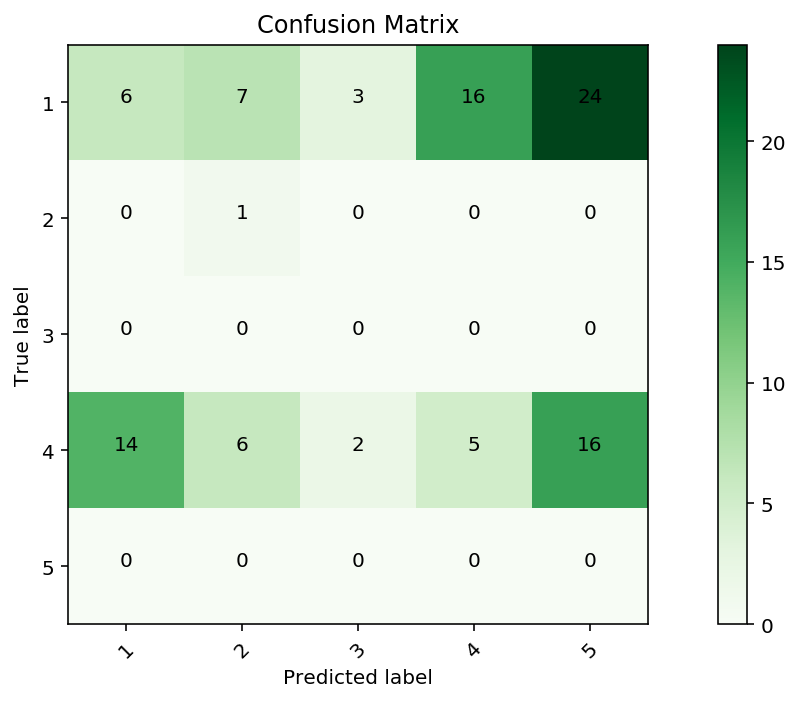

In [23]:
import itertools
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

cm = confusion_matrix(y_true=y_test, y_pred=y_actual)

plt.figure()
fig, ax = plt.subplots(figsize=(10,5))
plot_conf_mat(cm, 
              classes=['1', '2', '3', '4', '5'], 
              title='Confusion Matrix')
plt.show()

In [ ]:
%%javascript
Jupyter.notebook.save_checkpoint();
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>